# EE4375: Fourth Lab Session: Finite Element Method for the Poisson Equation on the Unit Interval

The **goals** of this fourth lab session of the [EE4375 Course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) are three-fold. 

The **first** goal is to implement a Galerkin finite element method using linear Lagrange shape functions to solve the one-dimensional Poisson equation supplied with Dirichlet and Neumann boundary conditions. The boundary value problem we intend to solver in this lab session is exactly the same as the boundary value problem we already solved in the second lab session. The assembly and the solve of the linear system will be explored. In the assembly process, a contribution per element to the matrix and right-hand side vector and a loop over elements is employed. The term element here refers to the interval that extends between two nodes of the mesh. Similarly to the second and third lab session, a sparse direct solver is employed to solve the resulting linear system. Unlike in the second lab session, non-uniform meshes can be employed. 

The **second** goal is to compare the numerical solution obtained with an one-dimensional analytical reference solution. The same reference solutions as in the second lab session can be employed. 

The **third** goal is apply the one-dimensional finite element method to a coil-core-air configuration. 

This lab session complements the lecture slides [block2-finite-element-method-1d.pdf](https://github.com/ziolai/finite_element_electrical_engineering/blob/main/slides/block2-finite-element-method-1d.pdf) available at [EE4375 GitHub Directory](https://github.com/ziolai/finite_element_electrical_engineering/tree/main/slides).

## Import Packages  

In [14]:
using LinearAlgebra 
using SparseArrays 
using StaticArrays

using Test
using BenchmarkTools

using Plots 

## Section 1: Introduction  

Section 2 introduces data structures and performs mesh generation. Section 3 assembles the stiffness matrix and the load vector. Section 4 solves the linear system. 

<b>Notes</b>
1. exercise: extend the struct Mesh to a parametric type with dofPerElement as parameter;
2. exercise: write assembly using map over the elements in the mesh; 

## Section 2: One-Dimensional Mesh Generation 

Observe the use of structs. 

In [78]:
"""
    struct Element 

The struct Element holds information for a single element. 
"""
struct Element
  p1::Float64    # coordinate left-most node
  p2::Float64    # coordinate right-most node
  e1::Int64      # global index left-most node
  e2::Int64      # global index right-most node
  area::Float64  # area (length) of the element 
end

"""
    struct Mesh 

The struct Mesh holds information for the entire mesh as an array of elements. 
"""
struct Mesh
  nnodes::Int64               # number of nodes including boundary nodes 
  nelements::Int64            # number of elements
  dofPerElement::Int64        # number of degrees of freedom per element 
  Elements::Array{Element,1}  # array of elements        
end 

Mesh

In [7]:
"""
    genMesh(nelements)

Generates a uniform uniform mesh on the unit interval with nelements number of elements 
"""
function genMesh(nelements)
    h = 1/nelements 
    nnodes = nelements+1
    dofPerElement = 2 
    x = Vector{Float64}(0:h:1)    
    Elements = Array{Element,1}(undef,nelements)
    for i in 1:nelements
        Elements[i] = Element(x[i],x[i+1],i,i+1,x[i+1]-x[i])
    end
    mesh = Mesh(nnodes,nelements,dofPerElement,Elements)     
    return mesh;
end 

"""
    genMesh(x)

Generates a mesh with nodes specified by x  
"""
function genMesh(x)
    nnodes = length(x)
    nelements = nnodes-1
    dofPerElement = 2 
    Elements = Array{Element,1}(undef,nelements)
    for i in 1:nelements
        Elements[i] = Element(x[i],x[i+1],i,i+1,x[i+1]-x[i])
    end
    mesh = Mesh(nnodes,nelements,dofPerElement,Elements)     
    return mesh;
end 

"""
    getNodes(mesh)

Generates a list of length nnodes of nodes in the mesh 
"""
function getNodes(mesh)
   return union([element.p1 for element in mesh.Elements], mesh.Elements[end].p2)
end 

"""
    getMidPoints(mesh)

Generaters a list of length nelements of element midpoints in the mesh 
"""
function getMidPoints(mesh)
    return [element.p1+element.area/2 for element in mesh.Elements]
end 

getMidPoints

In [89]:
# define test data  
testElement    = Element(0.,1/4,1,2,1/4)
testA          = sparse([4. -4 0 0 0; -4 8 4 0 0; 0 -4 8 -4 0; 0 0 -4 8 -4; 0 0 0 -4 4]) 
testfsource(x) = 1. 
testf          = [.125; .25; .25; .25; .125]
testu          = [0.; 0.; 0.0625; 0.0625; 0]
testux         = [0.; .25; 0.; -0.25]

# test mesh functions for correctness
mesh = genMesh(4)
@test mesh.nnodes == 5
@test mesh.nelements == 4
@test mesh.dofPerElement == 2  
@test mesh.Elements[1] == testElement

Test Passed

In [61]:
# test function for type stability 
# the text under Local @3 in orange font is caused by the for-loop and is considered to be harmless 
#@code_warntype genMesh(4);

In [62]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size 
@time genMesh(10);
@time genMesh(1000);
@time genMesh(10000);

  0.000004 seconds (2 allocations: 640 bytes)
  0.000005 seconds (3 allocations: 47.297 KiB)
  0.000056 seconds (4 allocations: 468.969 KiB)


## Section 3: Stiffness Matrix and Load Vector Assembly

Observe the use of static arrays to avoid redundant memory allocations and the use of the function sparse().  

### Section 1.3: Stiffness Matrix Assembly

In [63]:
"""
    genLocStiffMat(element::Element)

Generates local stiffness matrix. 
"""
function genLocStiffMat(element::Element)
    h     = element.area 
    v     = SVector(element.e1, element.e2)
    Iloc  = SVector{4}(v[i] for j=1:2, i=1:2) 
    Jloc  = SVector{4}(v[i] for i=1:2, j=1:2)
    Aloc  = SVector(1/h, -1/h, -1/h, 1/h) 
    return Iloc, Jloc, Aloc
end

"""
    genStiffMat(mesh::Mesh)

Generates global stiffness matrix 
"""
function genStiffMat(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofPerElement = mesh.dofPerElement
    dofPerElement2 = dofPerElement^2 

    #..set range vector 
    irng = SVector{4}(1:4)
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofPerElement2*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for element in mesh.Elements #..loop over number of elements..
        Iloc, Jloc, Aloc = genLocStiffMat(element) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc   
        irng = irng.+dofPerElement2
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end

genStiffMat

In [64]:
@test genLocStiffMat(testElement)[1] == [1, 1, 2, 2]
@test genLocStiffMat(testElement)[2] == [1, 2, 1, 2] 
@test genLocStiffMat(testElement)[3] == [4., -4., -4., 4.]
# A = genStiffMat(testMesh); @test sparse(A) == testA

Test Passed

In [65]:
mesh = genMesh(10);
#@code_warntype genStiffMat(mesh)

In [66]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time genStiffMat(mesh); # force function compilation 
mesh = genMesh(1000);  @time genStiffMat(mesh); 
mesh = genMesh(10000); @time genStiffMat(mesh); 

  0.000065 seconds (13 allocations: 3.078 KiB)
  0.000069 seconds (20 allocations: 228.312 KiB)
  0.000471 seconds (23 allocations: 2.214 MiB)


### Section 2.3: Load Vector Assembly 

In [67]:
"""
    genLocVec(element::Element)

Generates local load vector. 
"""
function genLocVec(element, sourceFct)
    h = element.area 
    Iloc = SVector(element.e1, element.e2)
    floc = (h/2)*SVector(sourceFct(element.p1), sourceFct(element.p2))
    return Iloc, floc
end

"""
    genVector(mesh, sourceFct::F) where F

Generates global load vector. 
"""
function genVector(mesh, sourceFct::F) where F 
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    f = zeros(Float64,nnodes)

    for element in mesh.Elements #..loop over number of elements..
        Iloc, floc = genLocVec(element,sourceFct) 
        f[Iloc] .+= floc          
    end
   
    return f; 
end

genVector

In [74]:
# test for correctness
@test genLocVec(testElement, testfsource)[1] == [1, 2]
@test genLocVec(testElement, testfsource)[2] == [0.125, 0.125]
@test genVector(testMesh, testfsource) == testf

Test Passed

In [68]:
#@code_warntype genVector(mesh, fsource)

In [75]:
# observe again how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time f = genVector(mesh,testfsource); # force function compilation
mesh = genMesh(1000);  @time f = genVector(mesh,testfsource);
mesh = genMesh(10000); @time f = genVector(mesh,testfsource);

  0.000059 seconds (1 allocation: 144 bytes)
  0.000017 seconds (1 allocation: 8.125 KiB)
  0.000019 seconds (2 allocations: 78.297 KiB)


## Section 4: Linear System Solve

In [76]:
"""
    genSolution(A,f)

Generates the finite element solution 
"""
function genSolution(A,f)
    #..handle essential boundary conditions 
    A[1,1] = 1.; A[1,2] = 0.; f[1] = 0.;
    A[end,end] = 1.; A[end,end-1] = 0.; f[end] = 0.;
    u = A\f 
    return u 
end

genSolution (generic function with 1 method)

In [83]:
# test correctness 
@test genSolution(testA,testf) ≈ testu

Test Passed

In [80]:
# observe again how the number of memory allocations only depends midly on the mesh size
# observe how assembly is much faster than the solve 
mesh = genMesh(10);    @time A = genStiffMat(mesh); f = genVector(mesh,testfsource); @time u = genSolution(A,f);
mesh = genMesh(1000);  @time A = genStiffMat(mesh); f = genVector(mesh,testfsource); @time u = genSolution(A,f);
mesh = genMesh(10000); @time A = genStiffMat(mesh); f = genVector(mesh,testfsource); @time u = genSolution(A,f);

  0.000015 seconds (14 allocations: 3.125 KiB)
  0.000057 seconds (78 allocations: 27.789 KiB)
  0.000049 seconds (21 allocations: 228.359 KiB)
  0.000540 seconds (80 allocations: 1.033 MiB)
  0.000486 seconds (24 allocations: 2.214 MiB)
  0.003161 seconds (86 allocations: 10.151 MiB)


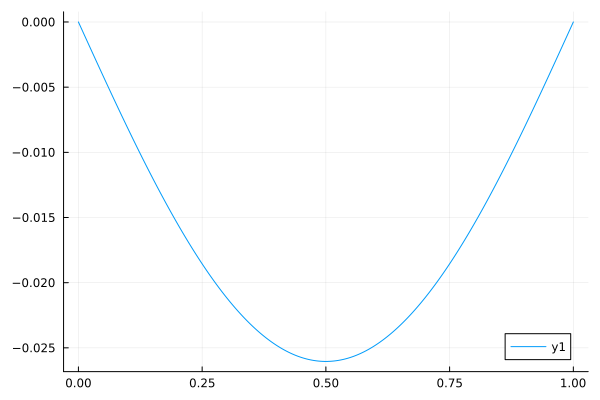

In [45]:
fsource(x) = x*(x-1)

N = 500; mesh = genMesh(N); x = getNodes(mesh)

A = genStiffMat(mesh)  
f = genVector(mesh,fsource) 
u = genSolution(A,f)

plot(x,u)

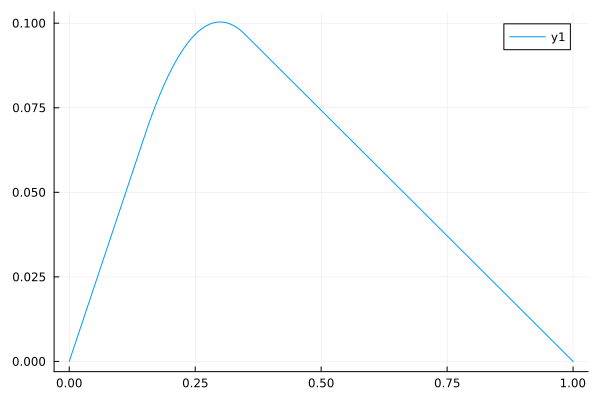

In [46]:
L = .5 
fsource(x) = 3*(x>(L/2-L/5))*(x<(L/2+L/5))

N = 500; mesh = genMesh(N); x = getNodes(mesh)

A = genStiffMat(mesh)  
f = genVector(mesh,fsource) 
u = genSolution(A,f)

plot(x,u)

## Section 5: Computing the Derivative

In [85]:
"""
    genDeriv(mesh, u)

Generates the derivative of the finite element solution.  
"""
function genDeriv(mesh, u)
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    du = zeros(Float64,nelements)

    for (i,element) in enumerate(mesh.Elements) #..loop over number of elements..
        h  = element.area 
        u1 = u[element.e1]
        u2 = u[element.e2]
        du[i] = (u2-u1)/h        
    end
   
    return du
end

genDeriv

In [90]:
@test genDeriv(testMesh,testu) == testux 

Test Passed

In [87]:
mesh = genMesh(10);    A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f); 
@time du = genDeriv(mesh,u); 
mesh = genMesh(1000);  A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f); @time du = genDeriv(mesh,u); 
mesh = genMesh(10000); A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f); @time du = genDeriv(mesh,u); 

  0.000043 seconds (1 allocation: 144 bytes)
  0.000054 seconds (1 allocation: 8.000 KiB)
  0.000020 seconds (2 allocations: 78.172 KiB)


## Section 6: Examples 

### Section 1.6: First Example 
Example with analytical reference solution. 

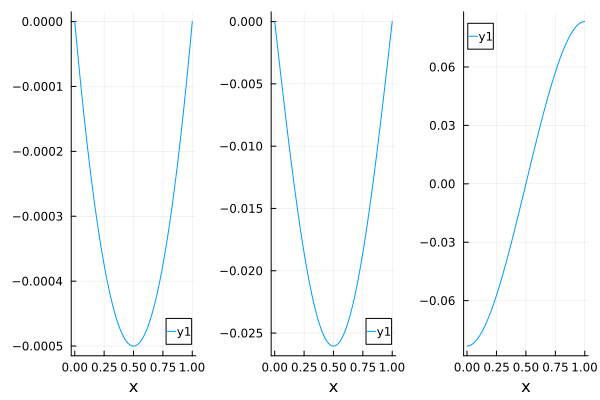

In [91]:
fsource(x) = x*(x-1)

N = 500; mesh = genMesh(N); x = getNodes(mesh); xmid = getMidPoints(mesh)

A  = genStiffMat(mesh)  
f  = genVector(mesh,fsource) 
u  = genSolution(A,f)
ux = genDeriv(mesh,u)

# post processing 
p1 = plot(x,f,xlabel="x")
p2 = plot(x,u,xlabel="x")
p3 = plot(xmid,ux,xlabel="x")
plot(p1,p2,p3,layout=(1,3))

### Section 2.6: Second Example
Example with locally defined source term $f(x)$. 

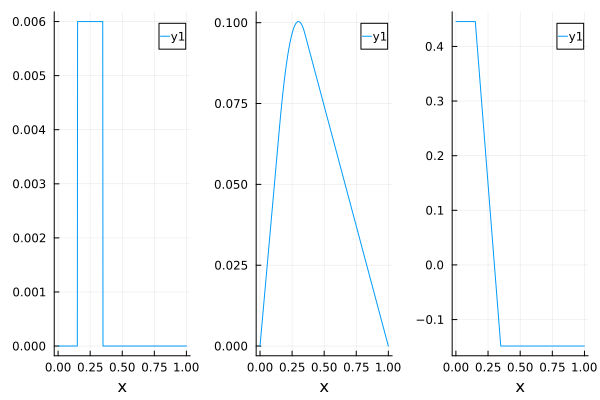

In [92]:
L = .5 
fsource(x) = 3*(x>(L/2-L/5))*(x<(L/2+L/5))

A  = genStiffMat(mesh)  
f  = genVector(mesh,fsource) 
u  = genSolution(A,f)
ux = genDeriv(mesh,u)

# post processing 
p1 = plot(x,f,xlabel="x")
p2 = plot(x,u,xlabel="x")
p3 = plot(xmid,ux,xlabel="x")
plot(p1,p2,p3,layout=(1,3))

## Section 7: Mesh Refinement Study 
Check converge to both $u(x)$ and $du/dx$ as the mesh is refined.  

## Section 8: Variable Diffusion Coefficient 
We change the Poisson equation to ... 

## Section 9: Zeroth Order Derivative and Mass Matrix Term 

## Sandbox